In [1]:
import pandas as pd
import  numpy as np

In [8]:
unified_ecoze=pd.read_csv("/Users/niharikadeokar/Desktop/ECOZE/unified_final_ecoze.csv")
unified_ecoze.head()

/var/folders/97/2wp359315j1fwr4xv957wy880000gn/T/ipykernel_35612/3892393539.py:1: DtypeWarning: Columns (8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  unified_ecoze=pd.read_csv("/Users/niharikadeokar/Desktop/ECOZE/unified_final_ecoze.csv")


,name,brand,price,image,description,department,aisle,shelf,recycling_info,ingredients,product_info,store,source_confidence,tesco_department,ecoze_category
0,Cadbury Christmas Snow Cake Bar 5 Pack,NaN,NaN,https://digitalcontent.api.tesco.com/v2/media/...,Chocolate flavoured sponge with a white chocol...,Bakery,"Cakes, Cake Bars, Slices & Pies","Small Cakes, Bites & Slices",Film. Recycle with bags at large supermarket -...,NaN,NaN,Tesco,NaN,Bakery,Food
1,New York Bakery Bagel Thins The Original 4 Pack,NaN,£1.20,https://digitalcontent.api.tesco.com/v2/media/...,4 Original Bagel Thins\nFor more great recipes...,Bakery,Bread & Rolls,Bagels,NaN,NaN,NaN,Tesco,NaN,Bakery,Food
2,Tesco Finest 4 Buttermilk Pancakes,NaN,NaN,https://digitalcontent.api.tesco.com/v2/media/...,4 Buttermilk pancakes.\nLight & Fluffy Enriche...,Bakery,"Crumpets, Muffins & Pancakes",Pancakes,Card. Recycle Film. Recycle at large supermarket,NaN,NaN,Tesco,NaN,Bakery,Food
3,Mission Deli Wheat & White Wraps 6 Pack 367G,NaN,NaN,https://digitalcontent.api.tesco.com/v2/media/...,6 Wheat Flour Tortilla Wraps with Wholemeal Fl...,Bakery,"Wraps, Pittas, Naan & Thins",Wraps,NaN,NaN,NaN,Tesco,NaN,Bakery,Food
4,Tesco Multiseed Batch 800G,NaN,NaN,https://digitalcontent.api.tesco.com/v2/media/...,Medium sliced white loaf with mixed seeds.\nMe...,Bakery,Bread & Rolls,Seeded Bread,Bag. Recycle at large supermarket,NaN,NaN,Tesco,NaN,Bakery,Food


In [14]:
fuzzy=pd.read_csv("/Users/niharikadeokar/Desktop/ECOZE/fuzzy_department_mappings.csv")
fuzzy.head()

,Store,Original Department,Fuzzy Match Category,Score
0,waitrose,Fresh & Chilled,Fresh Food,56.000000
1,waitrose,Household,Household,100.000000
2,waitrose,Frozen,Frozen Food,70.588235
3,waitrose,Food Cupboard,Food Cupboard,100.000000
4,waitrose,Bakery,Bakery,100.000000


In [32]:
out_csv_path = "unified_with_tesco_dept.csv"

df = unified_ecoze
map_df = fuzzy

def norm(s):
    return (str(s).strip().lower()) if pd.notna(s) else s

map_df = map_df.dropna(subset=["Original Department", "Fuzzy Match Category"]).copy()
map_df["dept_key"] = map_df["Original Department"].map(norm)
map_df = map_df.drop_duplicates(subset=["dept_key"], keep="first")

df["dept_key"] = df["department"].map(norm)

df = df.merge(
    map_df[["dept_key", "Fuzzy Match Category"]],
    on="dept_key",
    how="left"
)
df = df.rename(columns={"Fuzzy Match Category": "Fuzzy Match"})

FUZZY_CANONICAL = map_df["Fuzzy Match Category"].dropna().unique().tolist()
mask_fill = df["Fuzzy Match"].isna() & df["department"].isin(FUZZY_CANONICAL)
df.loc[mask_fill, "Fuzzy Match"] = df.loc[mask_fill, "department"]

df = df.drop(columns=["dept_key"])

df.to_csv(out_csv_path, index=False)

print("Done.")
print("Rows:", len(df))
print("New column added:", "Fuzzy Match")


Done.
Rows: 75900
New column added: Fuzzy Match


In [35]:
df.sample()

,name,brand,price,image,description,department,aisle,shelf,recycling_info,ingredients,product_info,store,source_confidence,tesco_department,ecoze_category,Fuzzy Match
15382,Tresemme 2 In 1 Shampoo & Conditioner 900Ml,NaN,NaN,https://digitalcontent.api.tesco.com/v2/media/...,Tresemme 2 In 1 Shampoo & Conditioner 900Ml\nC...,Health & Beauty,Shampoo,2 in 1 Shampoo,NaN,NaN,NaN,Tesco,NaN,Health & Beauty,Haircare & Styling,Health & Beauty


Rows compared: 57
Agreements: 49
Disagreements: 8
Agreement rate: 86.0%


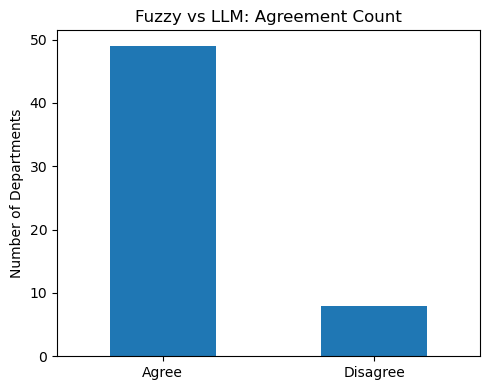

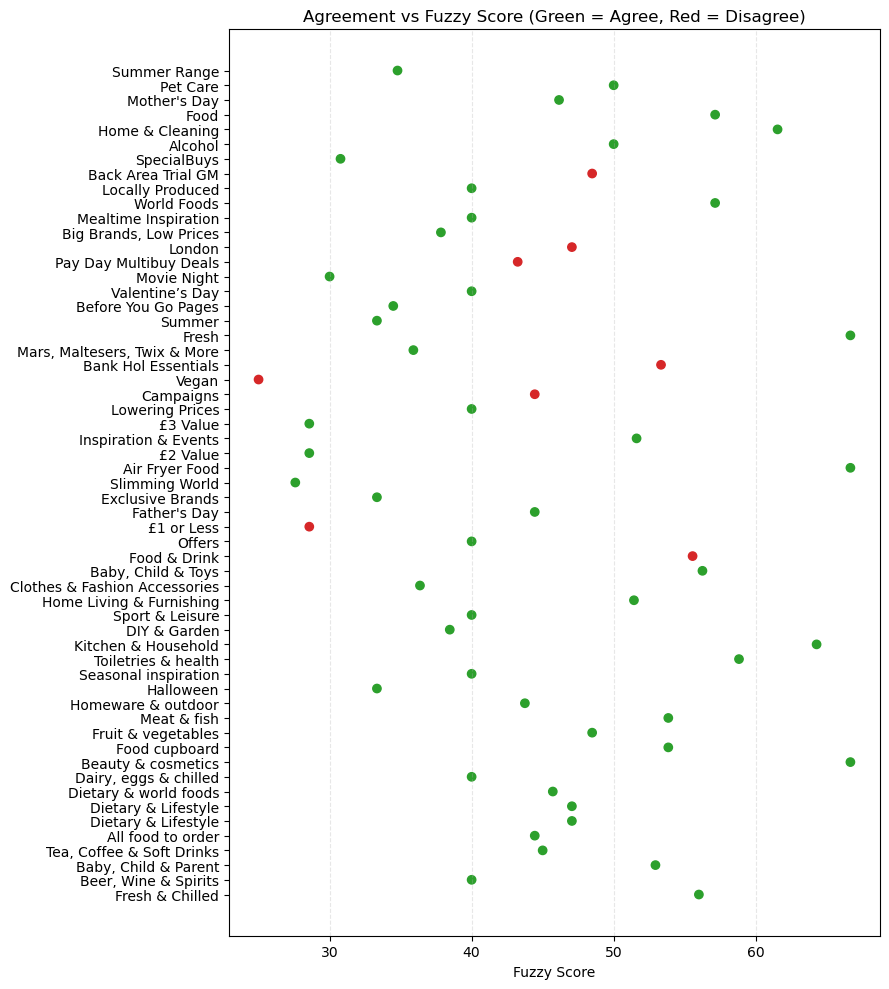

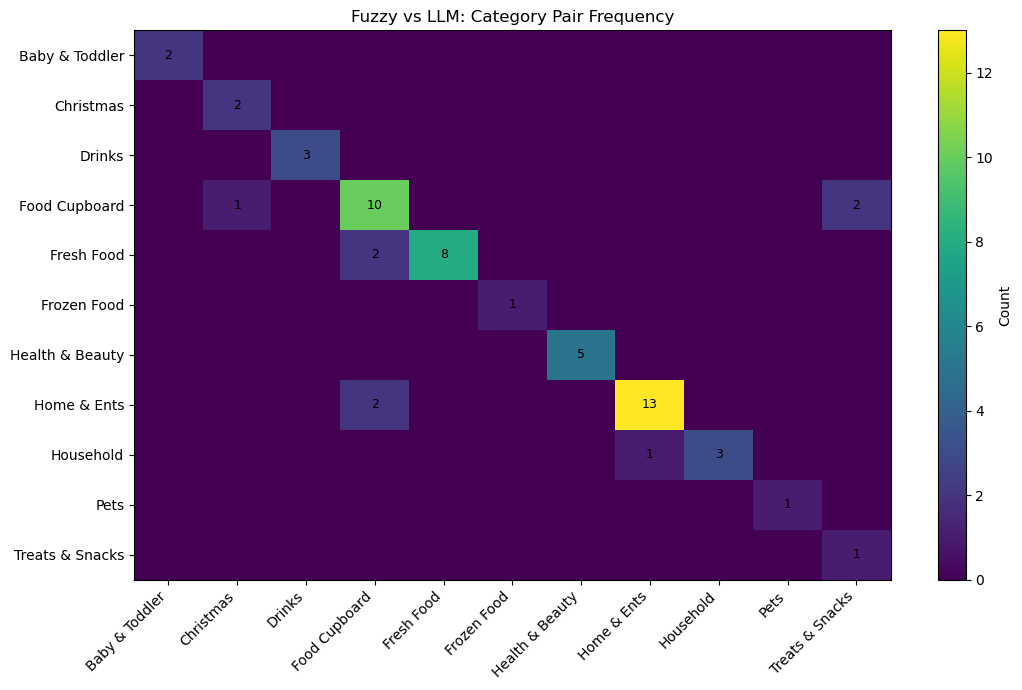

Top mismatches:


,Store,Original Department,Fuzzy Match Category,LLM Tesco Match,Score
35,iceland,Vegan,Fresh Food,Food Cupboard,25.000000
25,iceland,£1 or Less,Food Cupboard,Treats & Snacks,28.571429
43,iceland,Pay Day Multibuy Deals,Food Cupboard,Treats & Snacks,43.243243
34,iceland,Campaigns,Food Cupboard,Christmas,44.444444
44,iceland,London,Home & Ents,Food Cupboard,47.058824
49,iceland,Back Area Trial GM,Household,Home & Ents,48.484848
36,iceland,Bank Hol Essentials,Home & Ents,Food Cupboard,53.333333
23,lidl,Food & Drink,Fresh Food,Food Cupboard,55.555556


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fuzzy_df = pd.read_csv("/Users/niharikadeokar/Desktop/ECOZE/fuzzy_department_mappings.csv")
llm_df   = pd.read_csv("/Users/niharikadeokar/Desktop/ECOZE/llm_department_mappings.csv")

fuzzy_df.columns = [c.strip() for c in fuzzy_df.columns]
llm_df.columns   = [c.strip() for c in llm_df.columns]

comparison = fuzzy_df.merge(llm_df, on="Original Department", how="inner")
comparison["Match"] = comparison["Fuzzy Match Category"].fillna("") == comparison["LLM Tesco Match"].fillna("")

print("Rows compared:", len(comparison))
print("Agreements:", int(comparison["Match"].sum()))
print("Disagreements:", int((~comparison["Match"]).sum()))
print("Agreement rate: {:.1f}%".format(100*comparison["Match"].mean()))

plt.figure(figsize=(5,4))
(comparison["Match"]
 .value_counts()
 .rename(index={True:"Agree", False:"Disagree"})
 .plot(kind="bar"))
plt.title("Fuzzy vs LLM: Agreement Count")
plt.ylabel("Number of Departments")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,10))
ypos = np.arange(len(comparison))
color_map = comparison["Match"].map({True:"tab:green", False:"tab:red"})
plt.scatter(comparison["Score"], ypos, c=color_map)
plt.yticks(ypos, comparison["Original Department"])
plt.xlabel("Fuzzy Score")
plt.title("Agreement vs Fuzzy Score (Green = Agree, Red = Disagree)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


cross = (comparison
         .groupby(["Fuzzy Match Category", "LLM Tesco Match"])
         .size()
         .reset_index(name="count"))

pivot = cross.pivot(index="Fuzzy Match Category", columns="LLM Tesco Match", values="count").fillna(0)

plt.figure(figsize=(11,7))
plt.imshow(pivot.values, aspect='auto')
plt.title("Fuzzy vs LLM: Category Pair Frequency")
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha='right')
plt.yticks(range(pivot.shape[0]), pivot.index)
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = int(pivot.values[i, j])
        if val > 0:
            plt.text(j, i, str(val), ha='center', va='center', fontsize=9)
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()

mismatches = comparison.loc[~comparison["Match"],
                            ["Store","Original Department","Fuzzy Match Category","LLM Tesco Match","Score"]]
print("Top mismatches:")
display(mismatches.sort_values("Score"))  


In [40]:
unified.sample(5)

,name,brand,price,image,description,department,aisle,shelf,recycling_info,ingredients,product_info,store,source_confidence
12517,Tesco Grated Pecorino Cheese 50G,NaN,NaN,https://digitalcontent.api.tesco.com/v2/media/...,Grated Italian full fat hard vegetarian cheese...,Fresh Food,Cheese,Grated & Sliced Cheese,Film. Don't Recycle,NaN,NaN,Tesco,NaN
10687,BelVita Breakfast Soft Bakes Strawberry Filled...,NaN,£2.75,https://digitalcontent.api.tesco.com/v2/media/...,Soft baked biscuits made with wholegrain cerea...,Food Cupboard,Cereals,On The Go Breakfast,Board. Recycle Film. Don't Recycle,NaN,NaN,Tesco,NaN
30334,Fiona Cairns Lemon & Elderflower Loaf Cake,NaN,NaN,https://ecom-su-static-prod.wtrecom.com/images...,A Lemon sponge loaf cake topped & decorated wi...,Bakery,Cakes & Tarts,Loaf Cakes,NaN,NaN,NaN,Waitrose,NaN
2858,Estancia Pinot Noir 750Ml,NaN,£15.00,https://digitalcontent.api.tesco.com/v2/media/...,ESTANCIA PINOT NOIR 750ML\nOur Monterey County...,Drinks,Wine,Red Wine,NaN,NaN,NaN,Tesco,NaN
25244,Fage Total 5% Fat Greek Recipe Yogurt 450G,NaN,£3.50,https://digitalcontent.api.tesco.com/v2/media/...,Fage Total 5% Fat Greek Recipe Yogurt 450G\n3g...,Fresh Food,Yoghurts,Natural & Greek Yoghurt,NaN,NaN,NaN,Tesco,NaN


In [41]:
df=pd.read_csv("model-based.csv")
df.head(9)

,product_name,recycling_information,text_clean,predicted_category,predicted_category_rf,custom_recycle_category,Rule Based Recycle Category,Model-based Recycling Category,Rule-Based Recycle Category
0,Sparkling Water,"Bottle: PET plastic, Cap: HDPE plastic","bottle: pet plastic, cap: hdpe plastic",Recyclable,Recyclable,Recyclable,Recyclable,Recyclable,Recyclable
1,Tomato Sauce Jar,Glass jar with metal lid,glass jar with metal lid,Recyclable,Recyclable,Glass,Glass,Recyclable,Glass
2,Granola Pouch,"Mixed material pouch, check locally","mixed material pouch, check locally",Recyclable,Recyclable,Check Locally,Check Locally,Recyclable,Check Locally
3,Yogurt Cup,Plastic cup with foil lid,plastic cup with foil lid,Recyclable,Recyclable,Unknown,Unknown,Recyclable,Unknown
4,Compostable Cutlery,Biodegradable plant-based fork,biodegradable plant-based fork,Recyclable,Recyclable,Biodegradable,Biodegradable,Recyclable,Biodegradable
5,Baby Wipes Packet,"Plastic film, not currently recycled","plastic film, not currently recycled",Don't Recycle,Don't Recycle,Plastic,Plastic,Don't Recycle,Plastic
6,Crisps Bag,"Foil packet, not recyclable","foil packet, not recyclable",Recyclable,Recyclable,Not Recyclable,Not Recyclable,Recyclable,Not Recyclable
7,Cheese Slice Wrapper,"Plastic wrapper, check locally at supermarkets","plastic wrapper, check locally at supermarkets",Recyclable,Recyclable,Check Locally,Check Locally,Recyclable,Check Locally


In [46]:
df=df.drop('custom_recycle_category', axis=1)
df=df.drop('Rule Based Recycle Category', axis=1)
df.head(9)

,product_name,recycling_information,Model-based Recycling Category,Rule-Based Recycle Category
0,Sparkling Water,"Bottle: PET plastic, Cap: HDPE plastic",Recyclable,Recyclable
1,Tomato Sauce Jar,Glass jar with metal lid,Recyclable,Glass
2,Granola Pouch,"Mixed material pouch, check locally",Recyclable,Check Locally
3,Yogurt Cup,Plastic cup with foil lid,Recyclable,Unknown
4,Compostable Cutlery,Biodegradable plant-based fork,Recyclable,Biodegradable
5,Baby Wipes Packet,"Plastic film, not currently recycled",Don't Recycle,Plastic
6,Crisps Bag,"Foil packet, not recyclable",Recyclable,Not Recyclable
7,Cheese Slice Wrapper,"Plastic wrapper, check locally at supermarkets",Recyclable,Check Locally
